# Supercompressible: optimization 3d

This notebook intends to show the optimization process to maximize the absorbed energy in the 3D case. 

So, let's start by importing the required libraries:

In [1]:
# standard library
import pickle

# third-party
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
import scipy.optimize as so
from matplotlib.colors import ListedColormap
from GPyOpt.methods import BayesianOptimization
from GPyOpt.util.general import reshape

Now, let's import the data.

In [2]:
# get pandas frame
filename = 'DoE_results.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)
points = data['points']
print('variables:', [col for col in points.columns])

# get number of inputs
n_inputs = len(points.columns) - 3

# get X data
X = points.iloc[:,range(n_inputs)].values
X_full = points.iloc[:,range(n_inputs)].values

# get energy data
var_name = 'energy'
y = points.loc[:, var_name].values

# get coilable data
class_name = 'coilable'
y_class = points.loc[:, class_name].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))
print('y_class:', y_class)
print('y_class shape:', np.shape(y_class))

variables: ['ratio_d', 'ratio_pitch', 'ratio_top_diameter', 'coilable', 'sigma_crit', 'energy']
X: [[0.004      0.25       0.        ]
 [0.0385     0.875      0.4       ]
 [0.05575    0.5625     0.2       ]
 ...
 [0.06037836 1.08930969 0.58618164]
 [0.04312836 0.77680969 0.38618164]
 [0.00862836 1.40180969 0.78618164]]
X shape: (10000, 3)
y: [2.79529996e-04            nan 1.42853201e+01 ...            nan
            nan            nan]
y shape: (10000,)
y_class: [1. 0. 2. ... 0. 2. 0.]
y_class shape: (10000,)


The variables ```X``` and ```y``` contain all the data. Nevertheless, there's ```NaN``` values that cannot be considered.

In [3]:
for yy in np.unique(y_class):
    print('Class %i: %i' % (int(yy), np.sum(y_class==yy)))

Class 0: 3174
Class 1: 2013
Class 2: 4813


In [4]:
# missing indices
indices = pd.notnull(points.loc[:, var_name]).values

# get matching energy and coiling data
y = points.loc[indices, var_name].values
# y_class = points.loc[indices, class_name].values

# get X data
X = points.iloc[indices,range(n_inputs)].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))
print('y_class:', y_class)
print('y_class shape:', np.shape(y_class))

X: [[0.004      0.25       0.        ]
 [0.05575    0.5625     0.2       ]
 [0.0686875  0.328125   0.55      ]
 ...
 [0.06900336 0.30805969 0.68618164]
 [0.03450336 0.93305969 0.28618164]
 [0.02587836 0.46430969 0.18618164]]
X shape: (5264, 3)
y: [2.79529996e-04 1.42853201e+01 3.99711660e+01 ... 5.35333775e+01
 2.35352031e+00 6.15239445e-01]
y shape: (5264,)
y_class: [1. 0. 2. ... 0. 2. 0.]
y_class shape: (10000,)


Methods to create and evaluate the regression and classification models.

In [5]:
def make_gp_regression(X_train, y_train, kernel):
    
    # train model
    model = GaussianProcessRegressor(kernel=kernel, alpha=0.1**2, 
                                   n_restarts_optimizer=0)
    model.fit(X_train, y_train)
    
    return model

In [6]:
def split_data(X, y, train_size):
    
    # split data
    test_size = 1 - train_size
    indices = range(len(y))
    X_train = X[indices[:-int(round(len(indices) * test_size))]]
    X_test = X[indices[-int(round(len(indices) * test_size)):]]
    y_train = y[indices[:-int(round(len(indices) * test_size))]]
    y_test = y[indices[-int(round(len(indices) * test_size)):]]
    
    return (X_train, X_test, y_train, y_test)

In [7]:
def evaluate_model(model, X_test, y_mean_test, n_train):
    
    # predict test
    y_mean_pred = model.predict(X_test, return_std=False)

    # error metrics
    mse = mean_squared_error(y_mean_test, y_mean_pred)
    r2 = r2_score(y_mean_test, y_mean_pred)
    expl_var = explained_variance_score(y_mean_test, y_mean_pred)
    print("The mean squared error is %0.3e" % mse)
    print("The R2 score is %0.3f" % r2)
    print("The explained variance score is %0.3f" % expl_var)

    # plot predicted vs observed
    plt.figure()
    plt.plot(y_mean_test, y_mean_pred, 'o')
    plt.plot([np.min(y_mean_test), np.max(y_mean_test)], [np.min(y_mean_test), np.max(y_mean_test)], 'r-')
    plt.title('Posterior kernel: %s\n$n_{train} = %i$, $R^{2} = %0.3f$, $ MSE = %0.3e$' % (model.kernel_, n_train, r2, mse))
    plt.ylabel("Predicted")
    plt.xlabel("Observed")
    plt.show()

In [8]:
def evaluate_clf_model(clf, train_data, test_data, metrics=((accuracy_score, 'Accuracy classification score'),), print_results=True):
    
    # make predictions
    y_train_predicted = clf.predict(train_data[0])
    y_test_predicted = clf.predict(test_data[0])
    
    metric_results = []
    for Imetric in range(np.shape(metrics)[0]):
        metric = metrics[Imetric][0] # select metric used
        metric_results.append([metric(train_data[1], y_train_predicted), metric(test_data[1], y_test_predicted)])
        
        if print_results:
            print("Train", metrics[Imetric][1],"for ML model:", metric_results[-1][0])
            print("Test", metrics[Imetric][1],"for ML model:", metric_results[-1][1])
        
    return metric_results

Next, we will prepare the classification.

In [9]:
# choose train size
train_size = .8
(X_train, X_test, y_train, y_test) = split_data(X_full, y_class, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train
clf = SVC(kernel='rbf').fit(X_train_scaled, y_train)

# evaluate model
evaluate_clf_model(clf, (X_train_scaled, y_train), (X_test_scaled, y_test));

Train Accuracy classification score for ML model: 0.89025
Test Accuracy classification score for ML model: 0.8895


We can see that our classification is around 89% accurate.

Let's now clean the data to prepare it for the regression.

In [10]:
def perform_cleaning(X, y, n_std_cleaning):
    
    # compute threshold
    y_mean, y_std = np.mean(y), np.std(y)
    y_thresh = y_mean + n_std_cleaning * y_std

    # indices
    print(y_thresh)
    indices = np.where(y < y_thresh)
    n_dismissed_points = len(y) - len(indices[0])
    print('Dismissed points:', n_dismissed_points)

    # X and y
    y = y[indices]
    X = X[indices]
    print(np.shape(y))
    print(np.shape(X))

    return X, y, n_dismissed_points

In [11]:
n_std_cleaning = 5  # dismiss points that fall outside this range

n_dismissed_points = 1

y_dirty = y
X_dirty = X

while n_dismissed_points > 0:
    X, y, n_dismissed_points = perform_cleaning(X, y, n_std_cleaning)

251.41209785647746
Dismissed points: 6
(5258,)
(5258, 3)
78.83845527943124
Dismissed points: 7
(5251,)
(5251, 3)
76.83459344264611
Dismissed points: 0
(5251,)
(5251, 3)


We will now create a Gaussian Process regression model based on our data.

In [12]:
# choose train size
train_size = .1
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
kernel = 1.0 * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-1, 10.0))
model = make_gp_regression(X_train_scaled, y_train, kernel)

Now, _without_ using any optimization schemes, let us take a compare the maximizing input and maximized output.
We will make a distinction between regressor-predicted inputs/outputs and data-contained inputs/outputs.

In [13]:
X_rev_coilable = np.delete(X_dirty, np.where(clf.predict(scaler.transform(X_dirty)) != 1), 0)
Energy_rev_coilable_pred = np.delete(model.predict(scaler.transform(X_full)).reshape(-1, 1), np.where(clf.predict(scaler.transform(X_full)) != 1), 0)
Energy_rev_coilable_data = np.delete(y_dirty.reshape(-1, 1), np.where(clf.predict(scaler.transform(X_dirty)) != 1), 0)

maxX_data = X_rev_coilable[np.where(Energy_rev_coilable_data == max(Energy_rev_coilable_data))[0][0]]
maxX_pred = X_rev_coilable[np.where(Energy_rev_coilable_pred == max(Energy_rev_coilable_pred))[0][0]]

print("Data-contained maximizing parameters =", maxX_data)
print("Data-contained max. energy =", max(Energy_rev_coilable_data))
print("Predicted maximizing parameters =", maxX_pred)
print("Predicted max. energy =", max(Energy_rev_coilable_pred))

Data-contained maximizing parameters = [0.03710181 0.26312256 0.77441406]
Data-contained max. energy = [5.05723212]
Predicted maximizing parameters = [0.01721545 0.44302368 0.56689453]
Predicted max. energy = [6.37687343]


As expected, the GP regressor predicts a higher output value than the data contained within the dataset.

We now have our classification and regression models ready. We can use these functions to optimize for the absorbed energy while making sure that the coilability is favorable (class 1). We can do this by penalizing the other classes.

We will first use the `scipy.optimize` version of some common optimizers. To this end, let us define the objective function.

In [14]:
def objfun(x):
    penalty = 1e5
    x = [list(x)]
    if np.rint(clf.predict(scaler.transform(x))) == 1:
        return -model.predict(scaler.transform(x))
    else:
        return model.predict(scaler.transform(x)) + penalty

Please note that - for simplicity - we are disregarding to check whether a new iteration point is contained with in the design space.

Next, let us pick the method that we will use. All available methods are documented on scipy.

In [15]:
optMethod = 'Nelder-Mead' # e.g. Nelder-Mead, L-BFGS-B, TNC, SLSQP...

Let us create the boundaries of the design space.

In [16]:
variables = ['ratio_d', 'ratio_pitch', 'ratio_top_diameter']

bds0 = np.array([data['doe_variables'][name] for name in variables]).T
bds = so.Bounds(bds0[0], bds0[1])

It is time to perform the actual optimization!

In [34]:
x0 = [[0.04, 0.417, 0.8]] # Initial value which is found to be reversibly coilable

optval_NM = so.minimize(fun=objfun, x0=x0, bounds=bds, method='Nelder-Mead', tol=1e-5)
optval_TNC = so.minimize(fun=objfun, x0=x0, bounds=bds, method='TNC', tol=1e-5)
optval_LBFGSB = so.minimize(fun=objfun, x0=x0, bounds=bds, method='L-BFGS-B', tol=1e-5)

print('Nelder-Mead energy-optimizing parameters =', optval_NM.x)
print('Nelder-Mead optimized energy =', -optval_NM.fun)
print()
print('TNC energy-optimizing parameters =', optval_TNC.x)
print('TNC optimized energy =', -optval_TNC.fun[0])
print()
print('L-BFGS-B energy-optimizing parameters =', optval_LBFGSB.x)
print('L-BFGS-B optimized energy =', -optval_LBFGSB.fun[0])

Nelder-Mead energy-optimizing parameters = [0.0492386  0.28517214 0.84939197]
Nelder-Mead optimized energy = 21.87098975947881

TNC energy-optimizing parameters = [0.04002356 0.41708155 0.8       ]
TNC optimized energy = 9.934925557022737

L-BFGS-B energy-optimizing parameters = [0.04000785 0.41725762 0.8       ]
L-BFGS-B optimized energy = 9.920656159608226


Check whether the optimized input is classified as reversibly coilable or not:

In [37]:
print(clf.predict(scaler.transform([list(optval_NM.x)])))
print(clf.predict(scaler.transform([list(optval_TNC.x)])))
print(clf.predict(scaler.transform([list(optval_LBFGSB.x)])))

[1.]
[1.]
[1.]


Next, we will use Bayesian optimization. Here we will also provide the progression of the optimization steps, as well as the convergence plots.

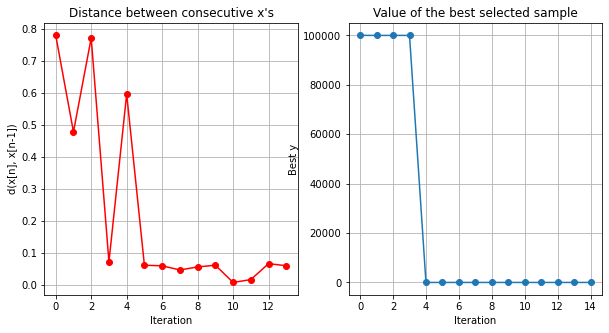

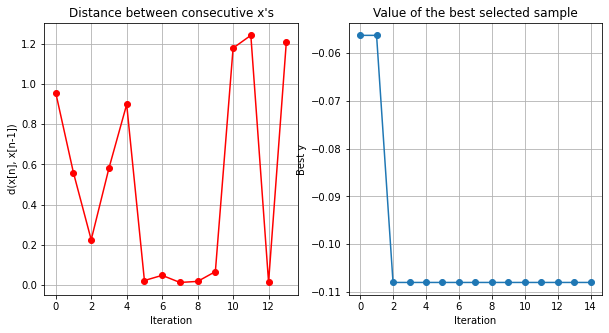

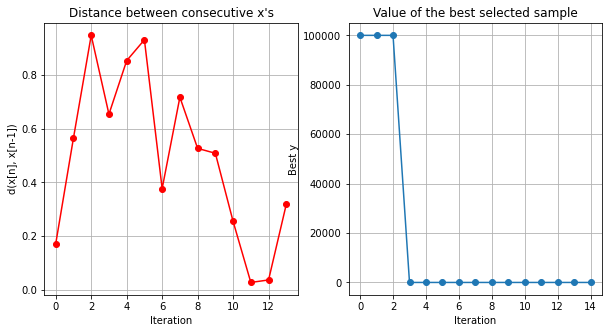

Progression of the approximated Expected Improvement function value:
[ 1.00024819e+05  1.00001190e+05  1.00001190e+05  1.00001190e+05
  6.91537697e-04 -9.46619531e-04 -6.68402083e-01 -1.60066776e+00
 -1.60066776e+00 -1.60066776e+00 -1.60066776e+00 -1.60066776e+00
 -1.60066776e+00 -1.60066776e+00 -1.60066776e+00]

Progression of the approximated Maximum Probability of Improvement function value:
[-0.05627419 -0.05627419 -0.10802265 -0.10802265 -0.10802265 -0.10802265
 -0.10802265 -0.10802265 -0.10802265 -0.10802265 -0.10802265 -0.10802265
 -0.10802265 -0.10802265 -0.10802265]

Progression of the approximated Lower Confidence Bound function value:
[ 1.00002780e+05  1.00002780e+05  1.00002780e+05 -2.83580471e-01
 -2.83580471e-01 -2.83580471e-01 -2.83580471e-01 -2.83580471e-01
 -2.83580471e-01 -2.83580471e-01 -2.83580471e-01 -2.83580471e-01
 -2.83580471e-01 -2.83580471e-01 -2.83580471e-01]


In [38]:
class funcClass:
    def __init__(self, input_dim):
        self.input_dim = input_dim
               
    def f(self, X):
        X = reshape(X, self.input_dim)
        fval = objfun(X[0])
                
        function=fval               
        return function

func = funcClass(input_dim=3)
f = func.f

domain = [{'name': 'ratio_d', 'type': 'continuous', 'domain': (0.004, 0.073)},
           {'name': 'ratio_pitch', 'type': 'continuous', 'domain': (0.25, 1.5)},
           {'name': 'ratio_top_diameter', 'type': 'continuous', 'domain': (0.0, 0.8)}]

# State the number of initial points and iterations
numberOfInitialPoints = 5
numberOfIterations = 10

# Define the type of acquisition function (EI, MPI, or LCB) and plot the obtained acquisition function
myBopt_EI = BayesianOptimization(f=f, acquisition_type='EI', domain=domain, normalize_Y=False, initial_design_numdata=numberOfInitialPoints)
myBopt_EI.run_optimization(max_iter=numberOfIterations)
myBopt_EI.plot_convergence() 

myBopt_MPI = BayesianOptimization(f=f, acquisition_type='MPI', domain=domain, normalize_Y=False, initial_design_numdata=numberOfInitialPoints)
myBopt_MPI.run_optimization(max_iter=numberOfIterations)
myBopt_MPI.plot_convergence()

myBopt_LCB = BayesianOptimization(f=f, acquisition_type='LCB', domain=domain, normalize_Y=False, initial_design_numdata=numberOfInitialPoints)
myBopt_LCB.run_optimization(max_iter=numberOfIterations)
myBopt_LCB.plot_convergence()

print("Progression of the approximated Expected Improvement function value:")
print(myBopt_EI.Y_best.reshape((len(myBopt_EI.Y_best))))
print()
print("Progression of the approximated Maximum Probability of Improvement function value:")
print(myBopt_MPI.Y_best.reshape((len(myBopt_MPI.Y_best))))
print()
print("Progression of the approximated Lower Confidence Bound function value:")
print(myBopt_LCB.Y_best.reshape((len(myBopt_LCB.Y_best))))